<a href="https://colab.research.google.com/github/BrianSantos66/recomendador_musicas/blob/main/recomendador/recomendador_pyspark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dicionário dos dados

https://developer.spotify.com/documentation/web-api/reference/#/operations/get-several-audio-features

* `Acousticness/Acústica:` Variável numérica, medida de confiança de 0,0 a 1,0 se a faixa é acústica. 1.0 representa alta confiança de que a faixa é acústica.

* `Danceability/Dançabilidade:` Variável numérica, a dançabilidade descreve o quão adequada uma faixa é para dançar com base em uma combinação de elementos musicais, incluindo tempo, estabilidade do ritmo, força da batida e regularidade geral. Um valor de 0,0 é o menos dançável e 1,0 é o mais dançável.

* `Duration_ms:`Variável numérica, a duração da trilha em milissegundos.

* `Duration_min:` Variável numérica, a duração da faixa em minutos.

* `Energy/Energia:` Variável numérica, Energia é uma medida de 0,0 a 1,0 e representa uma medida perceptiva de intensidade e atividade. Normalmente, as faixas energéticas parecem rápidas, altas e barulhentas. Por exemplo, o death metal tem alta energia, enquanto um prelúdio de Bach tem uma pontuação baixa na escala. As características perceptivas que contribuem para este atributo incluem faixa dinâmica, intensidade percebida, timbre, taxa de início e entropia geral.

* `Explicit/Explícito:` Variável categórica, se a faixa tem ou não letras explícitas (verdadeiro = sim (1); falso = não(0), não OU desconhecido).

* `Id:` O ID do Spotify para a faixa.

* `Instrumentalness/Instrumentalidade:` Variável numérica, prevê se uma faixa não contém vocais. Os sons “Ooh” e “aah” são tratados como instrumentais neste contexto. Faixas de rap ou de palavras faladas são claramente “vocais”. Quanto mais próximo o valor de instrumentalidade estiver de 1,0, maior a probabilidade de a faixa não conter conteúdo vocal. Valores acima de 0,5 destinam-se a representar faixas instrumentais, mas a confiança é maior à medida que o valor se aproxima de 1,0.

* `Key/Chave:`Variável numérica, a chave geral estimada da faixa. Os inteiros são mapeados para pitchs usando a notação padrão de Pitch Class. Por exemplo. 0 = C, 1 = C#/Db, 2 = D, e assim por diante. Se nenhuma chave foi detectada, o valor é -1.

* `Liveness/ Ao vivo:` Variável numérica, detecta a presença de um público na gravação. Valores mais altos de vivacidade representam uma probabilidade maior de que a faixa tenha sido executada ao vivo. Um valor acima de 0,8 fornece uma forte probabilidade de que a faixa esteja ativa.

* `Loudness/ Volume em dB:` Variável numérica, volume geral de uma faixa em decibéis (dB). Os valores de volume são calculados em média em toda a faixa e são úteis para comparar o volume relativo das faixas. A sonoridade é a qualidade de um som que é o principal correlato psicológico da força física (amplitude). Os valores típicos variam entre -60 e 0 db.

* `Mode/ Modo:` Variável numérica, o modo indica a modalidade (maior ou menor) de uma faixa, o tipo de escala da qual seu conteúdo melódico é derivado. Maior é representado por 1 e menor é 0.

* `Popularity/Popularidade:` Variável numérica, a popularidade de uma faixa é um valor entre 0 e 100, sendo 100 o mais popular. A popularidade é calculada por algoritmo e é baseada, em grande parte, no número total de execuções que a faixa teve e quão recentes são essas execuções.

* `Speechiness/Fala:` Variável numérica, a fala detecta a presença de palavras faladas em uma faixa. Quanto mais exclusivamente falada a gravação (por exemplo, talk show, audiolivro, poesia), mais próximo de 1,0 o valor do atributo. Valores acima de 0,66 descrevem faixas que provavelmente são feitas inteiramente de palavras faladas. Valores entre 0,33 e 0,66 descrevem faixas que podem conter música e fala, seja em seções ou em camadas, incluindo casos como música rap. Os valores abaixo de 0,33 provavelmente representam músicas e outras faixas que não são de fala.

* `Tempo:` Variável numérica, Tempo estimado geral de uma faixa em batidas por minuto (BPM). Na terminologia musical, tempo é a velocidade ou ritmo de uma determinada peça e deriva diretamente da duração média da batida.

* `Valence/Valência:` Variável numérica, Medida de 0,0 a 1,0 descrevendo a positividade musical transmitida por uma faixa. Faixas com alta valência soam mais positivas (por exemplo, feliz, alegre, eufórica), enquanto faixas com baixa valência soam mais negativas (por exemplo, triste, deprimida, irritada).

* `Year/Ano:` Ano em que a música foi lançada.

# Instalação das dependências e configuração do ambiente

In [ ]:
# Instalação do PySpark e importação das bibliotecas
!pip install pyspark
!pip install urllib3 --upgrade 
!pip install requests --upgrade 
!pip install spotipy --upgrade
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import PCA
from pyspark.sql.types import FloatType
from pyspark.ml.clustering import KMeans
from pyspark.ml.functions import vector_to_array
import pyspark.sql.functions as f
from pyspark.ml import Pipeline
from pyspark.sql import SparkSession
from pyspark import SparkFiles
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
from scipy.spatial.distance import euclidean
import matplotlib.pyplot as plt
from skimage import io
import spotipy
from spotipy.oauth2 import SpotifyOAuth, SpotifyClientCredentials

In [2]:
# Criação da seção
sessao_spark = SparkSession.builder\
                           .appName("Recomendador_PySpark")\
                           .getOrCreate()
sessao_spark

# Leitura e análise dos arquivos

In [3]:
# Importando o arquivo que contém os dados de cada música diretamento do GitHub para a sessão Spark
url_dados = 'https://github.com/IgorNascAlves/dados/blob/main/dados_musicas.csv?raw=true'
sessao_spark.sparkContext.addFile(url_dados)
path_dados_file = 'file://' + SparkFiles.get('dados_musicas.csv')

In [4]:
# Leitura do arquivo dentro do Spark
dados = sessao_spark.read.csv(path_dados_file, header=True, sep=';', inferSchema=True)

In [5]:
# Exibição do arquivo
dados.show(n=5, truncate=False)

+------------------+----+------------+------------+------------+-----------+------------------+--------+----------------------+----------------+---+--------+-------------------+----+-------------------+----------+-----------+-------+----------------------------+
|valence           |year|acousticness|artists     |danceability|duration_ms|energy            |explicit|id                    |instrumentalness|key|liveness|loudness           |mode|name               |popularity|speechiness|tempo  |artists_song                |
+------------------+----+------------+------------+------------+-----------+------------------+--------+----------------------+----------------+---+--------+-------------------+----+-------------------+----------+-----------+-------+----------------------------+
|0.285             |2000|0.00239     |Coldplay    |0.429       |266773     |0.6609999999999999|0       |3AJwUDP919kvQ9QcozQPxg|1.21E-4         |11 |0.234   |-7.227             |1   |Yellow             |84       

In [6]:
# Schema dos dados
dados.printSchema()

root
 |-- valence: double (nullable = true)
 |-- year: integer (nullable = true)
 |-- acousticness: double (nullable = true)
 |-- artists: string (nullable = true)
 |-- danceability: double (nullable = true)
 |-- duration_ms: integer (nullable = true)
 |-- energy: double (nullable = true)
 |-- explicit: integer (nullable = true)
 |-- id: string (nullable = true)
 |-- instrumentalness: double (nullable = true)
 |-- key: integer (nullable = true)
 |-- liveness: double (nullable = true)
 |-- loudness: double (nullable = true)
 |-- mode: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- popularity: integer (nullable = true)
 |-- speechiness: double (nullable = true)
 |-- tempo: double (nullable = true)
 |-- artists_song: string (nullable = true)



In [7]:
 # Quantidade de linhas do DataFrame
 dados.count()

20311

In [8]:
# Quantidade de colunas do DataFrame
len(dados.columns)

19

In [9]:
# Valores nulos por coluna
dados.select([f.count(f.when(f.isnull(c), 1)).alias(c) for c in dados.columns]).show()

+-------+----+------------+-------+------------+-----------+------+--------+---+----------------+---+--------+--------+----+----+----------+-----------+-----+------------+
|valence|year|acousticness|artists|danceability|duration_ms|energy|explicit| id|instrumentalness|key|liveness|loudness|mode|name|popularity|speechiness|tempo|artists_song|
+-------+----+------------+-------+------------+-----------+------+--------+---+----------------+---+--------+--------+----+----+----------+-----------+-----+------------+
|      0|   0|           0|      0|           0|          0|     0|       0|  0|               0|  0|       0|       0|   0|   0|         0|          0|    0|           0|
+-------+----+------------+-------+------------+-----------+------+--------+---+----------------+---+--------+--------+----+----+----------+-----------+-----+------------+



In [10]:
# Verificando os anos que temos na base 
print(sorted(dados.select('year').distinct().collect()))

[Row(year=2000), Row(year=2001), Row(year=2002), Row(year=2003), Row(year=2004), Row(year=2005), Row(year=2006), Row(year=2007), Row(year=2008), Row(year=2009), Row(year=2010), Row(year=2011), Row(year=2012), Row(year=2013), Row(year=2014), Row(year=2015), Row(year=2016), Row(year=2017), Row(year=2018), Row(year=2019), Row(year=2020)]


In [11]:
# Importando o arquivo que contém a média das caracteristicas por ano diretamento do GitHub para a sessão Spark
url_anos_dados = 'https://github.com/IgorNascAlves/dados/blob/main/dados_musicas_ano.csv?raw=true'

sessao_spark.sparkContext.addFile(url_anos_dados)
path_dados_file = 'file://' + SparkFiles.get('dados_musicas_ano.csv')

dados_anos = sessao_spark.read.csv(path_dados_file, header=True, inferSchema=True)

In [12]:
# Exibição do arquivo
dados_anos.show(n=5, truncate=False)

+----+----+------------------+------------------+------------------+-------------------+-------------------+------------------+-------------------+-------------------+------------------+-------------------+-------------------+---+
|mode|year|acousticness      |danceability      |duration_ms       |energy             |instrumentalness   |liveness          |loudness           |speechiness        |tempo             |valence            |popularity         |key|
+----+----+------------------+------------------+------------------+-------------------+-------------------+------------------+-------------------+-------------------+------------------+-------------------+-------------------+---+
|1   |1921|0.8868960000000005|0.4185973333333336|260537.16666666663|0.23181513333333334|0.34487805886666656|0.20571           |-17.04866666666665 |0.073662           |101.53149333333329|0.37932666666666665|0.6533333333333333 |2  |
|1   |1922|0.9385915492957748|0.4820422535211267|165469.74647887325|0.237815

In [13]:
# Filtrando dados para os anos maiores que 1999
dados_anos = dados_anos.filter('year >= 2000')
dados_anos.show()

+----+----+-------------------+------------------+------------------+------------------+-------------------+-------------------+-------------------+-------------------+------------------+------------------+------------------+---+
|mode|year|       acousticness|      danceability|       duration_ms|            energy|   instrumentalness|           liveness|           loudness|        speechiness|             tempo|           valence|        popularity|key|
+----+----+-------------------+------------------+------------------+------------------+-------------------+-------------------+-------------------+-------------------+------------------+------------------+------------------+---+
|   1|2000|0.28932270051635994| 0.590918047034764| 242724.6426380368|0.6254128323108387|0.10116776879345596| 0.1976860429447853| -8.247765848670758|0.08920541922290394| 118.9993231083843|0.5594754601226991|  46.6840490797546|  7|
|   1|2001| 0.2868424748428934|0.5833178553615969|240307.79600997505|0.626985522

In [14]:
# Quantidade de linhas do DataFrame
dados_anos.count()

21

In [15]:
# Quantidade de colunas do DataFrame
len(dados_anos.columns)

14

In [16]:
# Plotando a variação da variável loudness conforme os anos
fig = px.line(dados_anos.toPandas(), x='year', y='loudness', markers=True, title='Variação do loudness conforme os anos')
fig.show()

In [17]:
# Plotando variáveis para analisar a variação conforme o ano
fig = go.Figure()

temp = dados_anos.toPandas()

fig.add_trace(go.Scatter(x=temp['year'], y=temp['acousticness'], name='Acousticness'))
fig.add_trace(go.Scatter(x=temp['year'], y=temp['valence'],
                    name='Valence'))
fig.add_trace(go.Scatter(x=temp['year'], y=temp['danceability'],
                    name='Danceability'))
fig.add_trace(go.Scatter(x=temp['year'], y=temp['energy'],
                    name='Energy'))
fig.add_trace(go.Scatter(x=temp['year'], y=temp['instrumentalness'],
                    name='Instrumentalness'))
fig.add_trace(go.Scatter(x=temp['year'], y=temp['liveness'],
                    name='Liveness'))
fig.add_trace(go.Scatter(x=temp['year'], y=temp['speechiness'],
                    name='Speechiness'))

fig.show()


In [18]:
# Plotando a matriz de correlação
fig = px.imshow(dados_anos.drop('mode').toPandas().corr(), text_auto=True)
fig.show()

In [19]:
# Importando o arquivo que contém a média das caracteristicas por gênero diretamento do GitHub para a sessão Spark
url_dados_generos = 'https://github.com/IgorNascAlves/dados/blob/main/dados_musicas_genero.csv?raw=true'

sessao_spark.sparkContext.addFile(url_dados_generos)
path_dados_file = "file://" + SparkFiles.get("dados_musicas_genero.csv")

dados_generos = sessao_spark.read.csv(path_dados_file, header=True, inferSchema= True)

In [20]:
# Exibição do arquivo
dados_generos.show()

+----+--------------------+-------------------+-------------------+------------------+-------------------+--------------------+-------------------+-------------------+--------------------+------------------+-------------------+------------------+---+
|mode|              genres|       acousticness|       danceability|       duration_ms|             energy|    instrumentalness|           liveness|           loudness|         speechiness|             tempo|            valence|        popularity|key|
+----+--------------------+-------------------+-------------------+------------------+-------------------+--------------------+-------------------+-------------------+--------------------+------------------+-------------------+------------------+---+
|   1|21st century clas...| 0.9793333333333332|0.16288333333333335|160297.66666666663|0.07131666666666665|          0.60683367|             0.3616|-31.514333333333337| 0.04056666666666667|           75.3365|0.10378333333333334| 27.83333333333333| 

In [21]:
# Quantidade de linhas do DataFrame
dados_generos.count()

2973

In [22]:
# Contagem de Generos únicos
dados_generos.select('genres').distinct().count()

2973

In [23]:
# Quantidade de colunas do DataFrame
len(dados_generos.columns)

14

# Transformação dos dados para serem utilizados pelo modelo

## Vetorização, Padronização e PCA

In [24]:
# Definindo quais features serão utilizadas
X = dados_generos.columns
X.remove('genres')
X

['mode',
 'acousticness',
 'danceability',
 'duration_ms',
 'energy',
 'instrumentalness',
 'liveness',
 'loudness',
 'speechiness',
 'tempo',
 'valence',
 'popularity',
 'key']

In [25]:
# Vetorizando as features (Transformando todas as informações das colunas em uma linha só)
dados_generos_vector = VectorAssembler(inputCols= X, outputCol='features').transform(dados_generos).select(['features', 'genres'])

In [26]:
# Exibição dos dados
dados_generos_vector.show(n=5)

+--------------------+--------------------+
|            features|              genres|
+--------------------+--------------------+
|[1.0,0.9793333333...|21st century clas...|
|[1.0,0.49478,0.29...|               432hz|
|[1.0,0.762,0.7120...|               8-bit|
|[1.0,0.6514170195...|                  []|
|[1.0,0.6765573049...|          a cappella|
+--------------------+--------------------+
only showing top 5 rows



In [27]:
# Padronização dos dados (A padronização dimensiona cada variável separadamente subtraindo a média e dividindo pelo desvio padrão)
scaler = StandardScaler(inputCol='features', outputCol='scaled_features')
scaler_model = scaler.fit(dados_generos_vector)
dados_generos_scaler = scaler_model.transform(dados_generos_vector)

In [28]:
# Exibição dos dados
dados_generos_scaler.show(n=5)

+--------------------+--------------------+--------------------+
|            features|              genres|     scaled_features|
+--------------------+--------------------+--------------------+
|[1.0,0.9793333333...|21st century clas...|[2.68174831000279...|
|[1.0,0.49478,0.29...|               432hz|[2.68174831000279...|
|[1.0,0.762,0.7120...|               8-bit|[2.68174831000279...|
|[1.0,0.6514170195...|                  []|[2.68174831000279...|
|[1.0,0.6765573049...|          a cappella|[2.68174831000279...|
+--------------------+--------------------+--------------------+
only showing top 5 rows



In [29]:
# Aplicando o PCA (Reduz as features para um determinado número de componentes que explicam os dados)
pca = PCA(k=2, inputCol='scaled_features', outputCol='pca_features')
model_pca = pca.fit(dados_generos_scaler)
dados_generos_pca = model_pca.transform(dados_generos_scaler)

In [30]:
# Exibição dos dados
dados_generos_pca.select('pca_features').show(n=5, truncate=False)

+-----------------------------------------+
|pca_features                             |
+-----------------------------------------+
|[2.5070953668885667,0.43816913737697943] |
|[-0.5969679056633488,4.981612052751348]  |
|[-4.158460276223561,-0.8366525081079943] |
|[-2.387344878512217,-0.4877989015663404] |
|[-2.6501218371679083,-0.5756819768820474]|
+-----------------------------------------+
only showing top 5 rows



## Pipeline 

In [31]:
# Construção do pipeline que vetoriza, escala e realiza o PCA nos dados
pca_pipeline = Pipeline(stages=[VectorAssembler(inputCols= X, outputCol='features'),
                                StandardScaler(inputCol='features', outputCol='scaled_features'),
                                PCA(k=2, inputCol='scaled_features', outputCol='pca_features')])

In [32]:
# Treinando o modelo
pca_pipeline_model = pca_pipeline.fit(dados_generos)

In [33]:
# Gerando novas features
dados_generos_pca = pca_pipeline_model.transform(dados_generos)

In [34]:
# Exibição dos dados
dados_generos_pca.show(n=5)

+----+--------------------+------------------+-------------------+------------------+-------------------+--------------------+-------------------+-------------------+-------------------+------------------+-------------------+------------------+---+--------------------+--------------------+--------------------+
|mode|              genres|      acousticness|       danceability|       duration_ms|             energy|    instrumentalness|           liveness|           loudness|        speechiness|             tempo|            valence|        popularity|key|            features|     scaled_features|        pca_features|
+----+--------------------+------------------+-------------------+------------------+-------------------+--------------------+-------------------+-------------------+-------------------+------------------+-------------------+------------------+---+--------------------+--------------------+--------------------+
|   1|21st century clas...|0.9793333333333332|0.1628833333333333

# Modelo de Clustering (KMeans)

In [35]:
# Definindo a seed que será utilizada durante o projeto
SEED = 1224

In [36]:
# Instânciando o KMeans
kmeans = KMeans(featuresCol='pca_features', predictionCol='cluster_pca').setK(5).setSeed(SEED)

In [37]:
# Treinando o KMeans com as features geradas pelo pipeline
model_kmeans = kmeans.fit(dados_generos_pca)

In [38]:
# Definindo os cluster de cada música
predictions_kmeans = model_kmeans.transform(dados_generos_pca)

In [39]:
# Exibição dos cluster associados as features
predictions_kmeans.select('pca_features', 'cluster_pca').show()

+--------------------+-----------+
|        pca_features|cluster_pca|
+--------------------+-----------+
|[2.50709536688856...|          2|
|[-0.5969679056633...|          2|
|[-4.1584602762235...|          4|
|[-2.3873448785122...|          0|
|[-2.6501218371679...|          0|
|[-1.4965091203367...|          2|
|[-3.9235207721573...|          4|
|[-4.6110111098311...|          1|
|[-2.8376900630842...|          4|
|[-2.7066901398927...|          0|
|[-4.6983313839242...|          3|
|[-3.3759874966798...|          4|
|[-5.6089988770660...|          1|
|[0.29549463521176...|          2|
|[-2.5725591062870...|          0|
|[-3.4008228020493...|          4|
|[-4.3667203162634...|          4|
|[-2.7254698167724...|          4|
|[-4.9581123583816...|          3|
|[-3.6934951846422...|          3|
+--------------------+-----------+
only showing top 20 rows



In [40]:
# Criando novas colunas no DataFrame com base nos componentes do PCA
pca_features_xy = predictions_kmeans.withColumn('x', vector_to_array('pca_features')[0])\
                 .withColumn('y', vector_to_array('pca_features')[1])\
                 .select(['x', 'y', 'cluster_pca', 'genres'])

In [41]:
# Exibição dos dados
pca_features_xy.show()

+-------------------+-------------------+-----------+--------------------+
|                  x|                  y|cluster_pca|              genres|
+-------------------+-------------------+-----------+--------------------+
| 2.5070953668885667|0.43816913737697943|          2|21st century clas...|
|-0.5969679056633488|  4.981612052751348|          2|               432hz|
| -4.158460276223561|-0.8366525081079943|          4|               8-bit|
| -2.387344878512217|-0.4877989015663404|          0|                  []|
|-2.6501218371679083|-0.5756819768820474|          0|          a cappella|
| -1.496509120336763| 1.8644183183717797|          2|            abstract|
| -3.923520772157324| 0.2851835002352836|          4|      abstract beats|
| -4.611011109831114|-0.6783790472312378|          1|    abstract hip hop|
| -2.837690063084229|-0.5712993716580518|          4|           accordeon|
| -2.706690139892783|  -1.25937880797083|          0|           accordion|
|-4.6983313839242875| 1.2

In [42]:
# Plot dos clusters com base nos componetes criados pelo PCA
fig = px.scatter(pca_features_xy.toPandas(), x='x', y='y', color='cluster_pca', hover_data=['x', 'y', 'genres'])
fig.show()

In [43]:
# Conferindo o quão explicativos estão os componentes do PCA
pca_pipeline_model.stages[2].explainedVariance

DenseVector([0.2975, 0.1212])

O PCA tem como objetivo reduzir o número de features para 2 componentes (nesse caso), a célula acima mostra o quanto o PCA explica as features reduzidas, das 14 features o primeiro componente explica apenas 30%, enquanto o segundo componente explica apenas 12%, concluindo que reduzir para apenas 2 componentes não nos retorna um resultado satisfatório pois a muita perda de informação

In [44]:
# Definindo novas features
X = dados.columns
X.remove("artists")
X.remove("id")
X.remove("name")
X.remove("artists_song")
X

['valence',
 'year',
 'acousticness',
 'danceability',
 'duration_ms',
 'energy',
 'explicit',
 'instrumentalness',
 'key',
 'liveness',
 'loudness',
 'mode',
 'popularity',
 'speechiness',
 'tempo']

In [45]:
# Vetorização dos dados
dados_encoded_vector = VectorAssembler(inputCols=X, outputCol="features").transform(dados)
dados_encoded_vector.select("features").show(truncate=False, n=5)

+-------------------------------------------------------------------------------------------------------------------------+
|features                                                                                                                 |
+-------------------------------------------------------------------------------------------------------------------------+
|[0.285,2000.0,0.00239,0.429,266773.0,0.6609999999999999,0.0,1.21E-4,11.0,0.234,-7.227,1.0,84.0,0.0281,173.372]           |
|[0.613,2000.0,0.143,0.843,270507.0,0.8059999999999999,1.0,0.0,4.0,0.0771,-5.9460000000000015,0.0,80.0,0.269,94.948]      |
|[0.4,2000.0,0.00958,0.556,216880.0,0.8640000000000001,0.0,0.0,3.0,0.209,-5.87,0.0,84.0,0.0584,105.143]                   |
|[0.5429999999999999,2000.0,0.00664,0.545,233933.0,0.865,0.0,1.1E-5,11.0,0.168,-5.7079999999999975,0.0,78.0,0.0286,99.009]|
|[0.76,2000.0,0.0302,0.949,284200.0,0.6609999999999999,1.0,0.0,5.0,0.0454,-4.244,0.0,80.0,0.0572,104.504]                 |
+-------

In [46]:
# Padronização dos dados
scaler = StandardScaler(inputCol="features", outputCol="features_scaled")
model_scaler = scaler.fit(dados_encoded_vector)
dados_musicas_scaler = model_scaler.transform(dados_encoded_vector)

dados_musicas_scaler.select("features_scaled").show(truncate=False, n=5)

+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|features_scaled                                                                                                                                                                                                                                                               |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[1.156596679221045,329.8170613984441,0.008403188822334736,2.5040545743834373,3.7858811737298526,2.980511298201045,0.0,6.070790766862789E-4,3.0696424994844875,1.4832857988766257,-1.

In [47]:
# Definindo o número de componentes para ser utilizado pelo PCA
k = len(X)
k

15

In [48]:
# Aplicando o PCA utilizando 15 componentes (k)
pca = PCA(k=k, inputCol="features_scaled", outputCol="pca_features")
model_pca = pca.fit(dados_musicas_scaler)
dados_musicais_pca = model_pca.transform(dados_musicas_scaler)

In [49]:
# Conferindo a porcentagem de quanto os componentes conseguem explicar os dados 
sum(model_pca.explainedVariance) * 100

99.99999999999999

In [50]:
# Proporção que os componentes explicam a variação dos dados 
lista_valores = [sum(model_pca.explainedVariance[0:i+1]) for i in range(k)]
lista_valores

[0.21297354127107343,
 0.34597741622955064,
 0.43989805678254446,
 0.5267820578269102,
 0.6001038103117928,
 0.6665719513652388,
 0.7282174213581727,
 0.7845103843321022,
 0.8350002357002613,
 0.8812446547406768,
 0.9151737562703046,
 0.9435370133056037,
 0.9699018569070159,
 0.9900947792885578,
 0.9999999999999999]

In [51]:
# Definindo um novo número de componentes (k), onde seram levados em consideração apenas valores abaixo de 0.7
# Pois são os componentes que explicam melhor os dados 
k = sum(np.array(lista_valores) <= 0.7)
k

6

In [52]:
# Re-aplicando o PCA, agora com o novo valor do (k)
pca = PCA(k=k, inputCol="features_scaled", outputCol="pca_features")
model_pca = pca.fit(dados_musicas_scaler)
dados_musicas_pca_final = model_pca.transform(dados_musicas_scaler)

In [53]:
# Exibição dos dados
dados_musicas_pca_final.select("pca_features").show(truncate=False, n=5)

+----------------------------------------------------------------------------------------------------------------------+
|pca_features                                                                                                          |
+----------------------------------------------------------------------------------------------------------------------+
|[-34.71004464775704,-165.36848784906178,-11.163498729833321,-139.11374280854434,-14.152192300931375,6.254422223810391]|
|[-36.49885762774905,-167.85185045616555,-10.729023248907561,-135.904352656713,-13.388401890587229,3.9729807278308606] |
|[-35.460300916940554,-165.99633344577884,-11.361290348241592,-138.24276881247,-13.866654919305779,4.342675920458719]  |
|[-35.56301325520584,-165.59515096480607,-11.460226007031382,-137.52095740570041,-15.56854280392272,4.542073725584271] |
|[-36.54556974907567,-167.37512505802482,-11.881276527236555,-136.27798590243984,-14.05684799034454,3.583390145779156] |
+-------------------------------

In [54]:
# Conferindo a porcentagem de quanto os componentes conseguem explicar os dados 
sum(model_pca.explainedVariance) * 100

66.65719513652388

In [55]:
# Construção de um novo pipeline, agora com o número de componentes (k) definido como 6
pca_pipeline = Pipeline(stages=[VectorAssembler(inputCols=X, outputCol="features"),
                                StandardScaler(inputCol="features", outputCol="features_scaled"),
                                PCA(k=6, inputCol="features_scaled", outputCol="pca_features")])

In [56]:
# Treinando o modelo e gerando novas features
model_pca_pipeline = pca_pipeline.fit(dados)
projection = model_pca_pipeline.transform(dados)

In [57]:
# Exibição dos dados
projection.select("pca_features").show(truncate=False, n=5)

+----------------------------------------------------------------------------------------------------------------------+
|pca_features                                                                                                          |
+----------------------------------------------------------------------------------------------------------------------+
|[-34.71004464775704,-165.36848784906178,-11.163498729833321,-139.11374280854434,-14.152192300931375,6.254422223810391]|
|[-36.49885762774905,-167.85185045616555,-10.729023248907561,-135.904352656713,-13.388401890587229,3.9729807278308606] |
|[-35.460300916940554,-165.99633344577884,-11.361290348241592,-138.24276881247,-13.866654919305779,4.342675920458719]  |
|[-35.56301325520584,-165.59515096480607,-11.460226007031382,-137.52095740570041,-15.56854280392272,4.542073725584271] |
|[-36.54556974907567,-167.37512505802482,-11.881276527236555,-136.27798590243984,-14.05684799034454,3.583390145779156] |
+-------------------------------

In [58]:
# Instânciando o KMeans, com o número de cluster em 50
kmeans = KMeans(k=50, featuresCol="pca_features", predictionCol="cluster_pca", seed=SEED)

In [59]:
# Treinando o modelo e gerando os clusters
modelo_kmeans = kmeans.fit(projection)
projection_kmeans = modelo_kmeans.transform(projection)

In [60]:
# Exibição dos clusters criados
projection_kmeans.select(["pca_features", "cluster_pca"]).show()

+--------------------+-----------+
|        pca_features|cluster_pca|
+--------------------+-----------+
|[-34.710044647757...|          8|
|[-36.498857627749...|          4|
|[-35.460300916940...|         35|
|[-35.563013255205...|         16|
|[-36.545569749075...|         34|
|[-36.713222290262...|         34|
|[-36.013246178822...|         34|
|[-36.542687712104...|         23|
|[-36.425249009784...|         16|
|[-35.872074915770...|         34|
|[-31.639065936568...|         44|
|[-35.661446890546...|         34|
|[-35.574542234850...|         32|
|[-36.022399748656...|         13|
|[-34.336941950985...|         35|
|[-35.096906055142...|         49|
|[-35.202423054032...|         38|
|[-34.942948671026...|         30|
|[-36.617404517517...|          4|
|[-34.296973387410...|          6|
+--------------------+-----------+
only showing top 20 rows



In [61]:
# Criando novas colunas no DataFrame com base nos componentes do PCA
projection_kmeans = projection_kmeans.withColumn('x', vector_to_array("pca_features")[0])\
                                     .withColumn('y', vector_to_array("pca_features")[1])

projection_kmeans.select(['x', 'y', 'cluster_pca', 'artists_song']).show(n=5, truncate=False)

+-------------------+-------------------+-----------+----------------------------+
|x                  |y                  |cluster_pca|artists_song                |
+-------------------+-------------------+-----------+----------------------------+
|-34.71004464775704 |-165.36848784906178|8          |Coldplay - Yellow           |
|-36.49885762774905 |-167.85185045616555|4          |OutKast - Ms. Jackson       |
|-35.460300916940554|-165.99633344577884|35         |Linkin Park - In the End    |
|-35.56301325520584 |-165.59515096480607|16         |3 Doors Down - Kryptonite   |
|-36.54556974907567 |-167.37512505802482|34         |Eminem - The Real Slim Shady|
+-------------------+-------------------+-----------+----------------------------+
only showing top 5 rows



In [62]:
# Plot dos clusters com base nos novos componetes criados pelo PCA
fig = px.scatter(projection_kmeans.toPandas(), x="x", y="y", color="cluster_pca", hover_data=['artists_song'])
fig.show()

# Recomendador de músicas

In [75]:
# Função que procura pelas músicas que estejam nos mesmos clusters
def recomendador(nome_musica):
  cluster = projection_kmeans.filter(projection_kmeans.artists_song == nome_musica).select('cluster_pca').collect()[0][0]

  musicas_recomendadas = projection_kmeans.filter(projection_kmeans.cluster_pca == cluster)\
                                        .select('artists_song', 'id', 'pca_features')
  
  componentes_musica = musicas_recomendadas.filter(musicas_recomendadas.artists_song == nome_musica)\
                                         .select('pca_features').collect()[0][0]
 
# Função que calcula o quão semelhante são as músicas recomendadas 
  def calcula_distance(value):
    return euclidean(componentes_musica, value)

  udf_calcula_distance = f.udf(calcula_distance, FloatType())
  musicas_recomendadas_dist = musicas_recomendadas.withColumn('Dist', udf_calcula_distance('pca_features'))
  recomendadas = sessao_spark.createDataFrame(musicas_recomendadas_dist.sort('Dist').take(10)).select(['artists_song', 'id', 'Dist'])

# Coletando informações da API do Spotify
  playlist_id = recomendadas.select('id').collect()
  
  name = []
  url = []
  for i in playlist_id:
      track = sp.track(i[0])
      url.append(track["album"]["images"][1]["url"])
      name.append(track["name"])

# Plotando capas
  plt.figure(figsize=(15,10))
  columns = 5
  for i, u in enumerate(url):
      ax = plt.subplot(len(url) // columns + 1, columns, i + 1)
      image = io.imread(u)
      plt.imshow(image)
      ax.get_yaxis().set_visible(False)
      plt.xticks(color = 'w', fontsize = 0.1)
      plt.yticks(color = 'w', fontsize = 0.1)
      plt.xlabel(name[i], fontsize = 10)
      plt.tight_layout(h_pad=0.7, w_pad=0)
      plt.subplots_adjust(wspace=None, hspace=None)
      plt.grid(visible=None)
  plt.show()

# Função que retorna todas as músicas do artista/banda
def listar_musicas(artista):
  consulta = projection_kmeans.filter(projection_kmeans.artists == artista).select(projection_kmeans.artists_song.alias("Músicas disponíveis"))
  consulta.show(n=100, truncate=False)

# Função que verifica se o artista/banda existe na base de dados
def encontra_artista(artista):
  verifica = projection_kmeans.filter(projection_kmeans.artists == artista).collect()
  if len(verifica) > 0: return print('Banda disponível!')
  else: return print('Banda indisponível!') 

## Conectando com o spotify

In [78]:
# Configurações necessárias para usar a API do Spotify
scope = "user-library-read playlist-modify-private"

OAuth = SpotifyOAuth(
        scope=scope,         
        redirect_uri='http://localhost:5000/callback',
        client_id = 'e6f683d8a7504fb196df08bb64afc477',
        client_secret = 'c3eabb977f8b4dde812ec37549ca8d83')
      
client_credentials_manager = SpotifyClientCredentials(client_id = 'e6f683d8a7504fb196df08bb64afc477',
                                                      client_secret = 'c3eabb977f8b4dde812ec37549ca8d83')

sp = spotipy.Spotify(client_credentials_manager = client_credentials_manager)

## Recomendador!

In [126]:
encontra_artista("Metallica")

Banda disponível!


In [127]:
listar_musicas("Metallica")

+------------------------------------+
|Músicas disponíveis                 |
+------------------------------------+
|Metallica - I Disappear             |
|Metallica - St. Anger               |
|Metallica - The Day That Never Comes|
|Metallica - All Nightmare Long      |
|Metallica - The Unforgiven III      |
|Metallica - Frantic                 |
|Metallica - Broken, Beat & Scarred  |
|Metallica - My Apocalypse           |
|Metallica - Cyanide                 |
|Metallica - Hardwired               |
|Metallica - Some Kind Of Monster    |
|Metallica - That Was Just Your Life |
|Metallica - The End Of The Line     |
|Metallica - Moth Into Flame         |
|Metallica - Suicide & Redemption    |
|Metallica - Now That We're Dead     |
+------------------------------------+



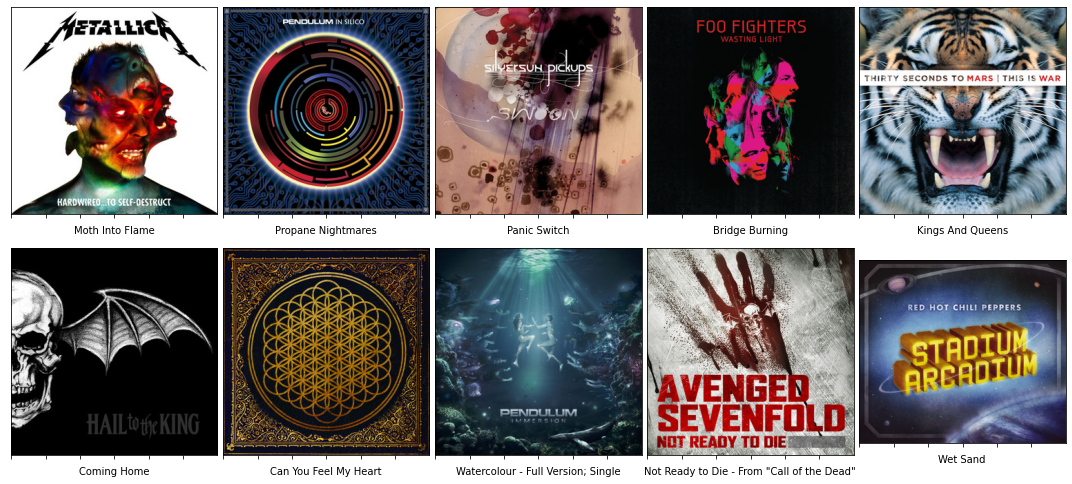

In [129]:
recomendador("Metallica - Moth Into Flame")